# EV Adoption Forecasting

In [1]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [2]:
df = pd.read_csv('Electric_Vehicle_Population_Size_History_By_County_.csv')
df.head(10)

,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
0,September 30 2022,Riverside,CA,Passenger,7,0,7,460,467,1.50
1,December 31 2022,Prince William,VA,Passenger,1,2,3,188,191,1.57
2,January 31 2020,Dakota,MN,Passenger,0,1,1,32,33,3.03
3,June 30 2022,Ferry,WA,Truck,0,0,0,"3,575","3,575",0.00
4,July 31 2021,Douglas,CO,Passenger,0,1,1,83,84,1.19
5,May 31 2018,Maui,HI,Passenger,1,0,1,59,60,1.67
6,November 30 2017,Northampton,PA,Passenger,0,1,1,66,67,1.49
7,March 31 2018,Nassau,NY,Passenger,1,0,1,37,38,2.63
8,March 31 2020,DeKalb,IN,Passenger,1,0,1,1,2,50.00
9,January 31 2019,Columbia,WA,Truck,0,0,0,"1,529","1,529",0.00


In [3]:
print("no of rows:",df.shape[0])
print("no of columns:",df.shape[1])

no of rows: 20819
no of columns: 10


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20819 entries, 0 to 20818
Data columns (total 10 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Date                                      20819 non-null  object 
 1   County                                    20733 non-null  object 
 2   State                                     20733 non-null  object 
 3   Vehicle Primary Use                       20819 non-null  object 
 4   Battery Electric Vehicles (BEVs)          20819 non-null  object 
 5   Plug-In Hybrid Electric Vehicles (PHEVs)  20819 non-null  object 
 6   Electric Vehicle (EV) Total               20819 non-null  object 
 7   Non-Electric Vehicle Total                20819 non-null  object 
 8   Total Vehicles                            20819 non-null  object 
 9   Percent Electric Vehicles                 20819 non-null  float64
dtypes: float64(1), object(9)
memory us

In [5]:
df.describe()

,Percent Electric Vehicles
count,20819.000000
mean,4.139216
std,11.055350
min,0.000000
25%,0.390000
50%,1.220000
75%,2.995000
max,100.000000


In [6]:
df.isnull().sum()

Date                                         0
County                                      86
State                                       86
Vehicle Primary Use                          0
Battery Electric Vehicles (BEVs)             0
Plug-In Hybrid Electric Vehicles (PHEVs)     0
Electric Vehicle (EV) Total                  0
Non-Electric Vehicle Total                   0
Total Vehicles                               0
Percent Electric Vehicles                    0
dtype: int64

# Preprocessing the dataset

In [7]:
#IQR to find the upper and lower bounds

Q1 = df['Percent Electric Vehicles'].quantile(0.25)
Q3 = df['Percent Electric Vehicles'].quantile(0.75)
IQR = Q3 - Q1


lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print('lower_bound:', lower_bound)
print('upper_bound:', upper_bound)


outliers = df[(df['Percent Electric Vehicles'] < lower_bound) | (df['Percent Electric Vehicles'] > upper_bound)]
print("Number of outliers in 'Percent Electric Vehicles':", outliers.shape[0])

lower_bound: -3.5174999999999996
upper_bound: 6.9025
Number of outliers in 'Percent Electric Vehicles': 2476


In [11]:
#columns cleanup
columns_to_check = [
    'Battery Electric Vehicles (BEVs)',
    'Plug-In Hybrid Electric Vehicles (PHEVs)',
    'Electric Vehicle (EV) Total',
    'Non-Electric Vehicle Total',
    'Total Vehicles',
    'Percent Electric Vehicles'
]

for col in columns_to_check:
    df[col] = pd.to_numeric(df[col], errors='coerce')
#it is optional but checks Nan or missing through every columns
print(df[columns_to_check].describe())

print(df[columns_to_check].dtypes)


       Battery Electric Vehicles (BEVs)  \
count                      20266.000000   
mean                          25.855176   
std                          102.004224   
min                            0.000000   
25%                            0.000000   
50%                            1.000000   
75%                            2.000000   
max                          999.000000   

       Plug-In Hybrid Electric Vehicles (PHEVs)  Electric Vehicle (EV) Total  \
count                              20468.000000                 20119.000000   
mean                                  21.790942                    31.623093   
std                                   92.309729                   115.742017   
min                                    0.000000                     0.000000   
25%                                    0.000000                     1.000000   
50%                                    1.000000                     1.000000   
75%                                    1.000000     

In [12]:
#date parsing
df.loc[:, 'Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

df = df[df['Date'].notnull()]

df=df[df['Electric Vehicle (EV) Total'].notnull()]
df['County']=df['County'].fillna('Unknown')
df['State']=df['State'].fillna('Unknown')

print("Missing After fill:")
print(df[['County','State']].isnull().sum())
df.head()

Missing After fill:
County    0
State     0
dtype: int64


,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
0,2022-09-30,Riverside,CA,Passenger,7.0,0.0,7.0,460.0,467.0,1.50
1,2022-12-31,Prince William,VA,Passenger,1.0,2.0,3.0,188.0,191.0,1.57
2,2020-01-31,Dakota,MN,Passenger,0.0,1.0,1.0,32.0,33.0,3.03
3,2022-06-30,Ferry,WA,Truck,0.0,0.0,0.0,NaN,NaN,0.00
4,2021-07-31,Douglas,CO,Passenger,0.0,1.0,1.0,83.0,84.0,1.19


In [13]:
#checking for duplicates
print("Any duplicates:", df.duplicated().any())
print("Number of duplicate rows:", df.duplicated().sum())

Any duplicates: False
Number of duplicate rows: 0


In [14]:
df['Percent Electric Vehicles'] = np.where(df['Percent Electric Vehicles'] > upper_bound, upper_bound,
                                 np.where(df['Percent Electric Vehicles'] < lower_bound, lower_bound, df['Percent Electric Vehicles']))

# Identify outliers
outliers = df[(df['Percent Electric Vehicles'] < lower_bound) | (df['Percent Electric Vehicles'] > upper_bound)]
print("Number of outliers in 'Percent Electric Vehicles':", outliers.shape[0])

Number of outliers in 'Percent Electric Vehicles': 0


In [15]:
# Most EVs by County
top_counties = df.groupby('County')['Electric Vehicle (EV) Total'].sum().sort_values(ascending=False).head(3)
bottom_counties = df.groupby('County')['Electric Vehicle (EV) Total'].sum().sort_values().head(3)

print("Top 3 Counties:\n", top_counties)
print("\nBottom 3 Counties:\n", bottom_counties)

Top 3 Counties:
 County
Clallam      39839.0
Jefferson    39683.0
San Juan     39309.0
Name: Electric Vehicle (EV) Total, dtype: float64

Bottom 3 Counties:
 County
Brown         1.0
Hood River    1.0
Union         1.0
Name: Electric Vehicle (EV) Total, dtype: float64


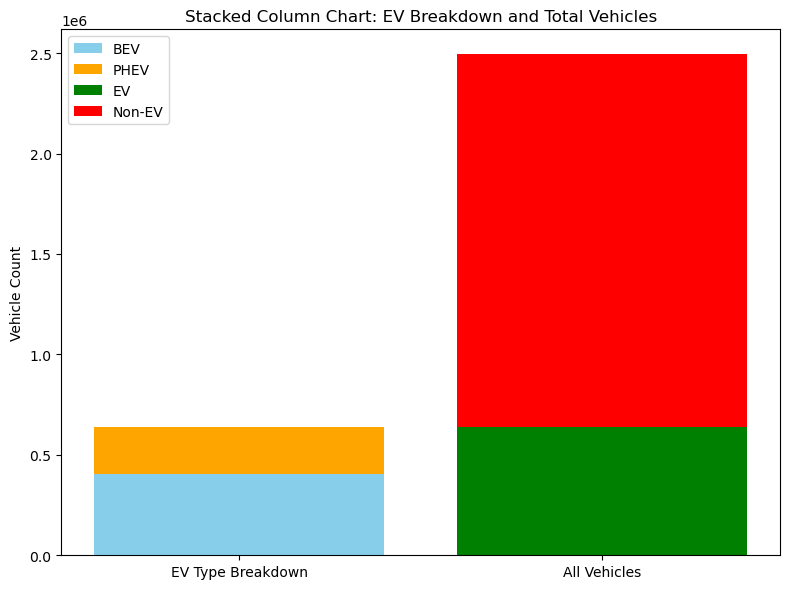

In [16]:
# Total sums for stacked column chart
bev_total = df['Battery Electric Vehicles (BEVs)'].sum()
phev_total = df['Plug-In Hybrid Electric Vehicles (PHEVs)'].sum()
ev_total = df['Electric Vehicle (EV) Total'].sum()
non_ev_total = df['Non-Electric Vehicle Total'].sum()
all_total = df['Total Vehicles'].sum()

fig, ax = plt.subplots(figsize=(8, 6))

ax.bar('EV Type Breakdown', bev_total, label='BEV', color='skyblue')
ax.bar('EV Type Breakdown', phev_total, bottom=bev_total, label='PHEV', color='orange')

ax.bar('All Vehicles', ev_total, label='EV', color='green')
ax.bar('All Vehicles', non_ev_total, bottom=ev_total, label='Non-EV', color='red')

ax.set_ylabel('Vehicle Count')
ax.set_title('Stacked Column Chart: EV Breakdown and Total Vehicles')
ax.legend()
plt.tight_layout()
plt.show()

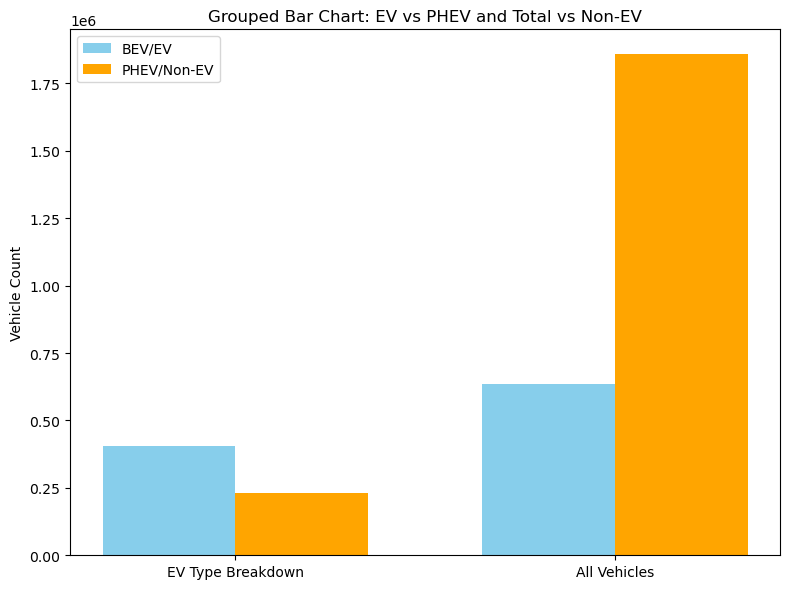

In [17]:
#Comparing BEV and PHEV side-by-side across categories
labels = ['EV Type Breakdown', 'All Vehicles']
bev_data = [bev_total, ev_total]
phev_data = [phev_total, non_ev_total]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, bev_data, width, label='BEV/EV', color='skyblue')
rects2 = ax.bar(x + width/2, phev_data, width, label='PHEV/Non-EV', color='orange')

ax.set_ylabel('Vehicle Count')
ax.set_title('Grouped Bar Chart: EV vs PHEV and Total vs Non-EV')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.tight_layout()
plt.show()


In [18]:
df = df.copy()

df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['numeric_date'] = df['Date'].dt.year * 12 + df['Date'].dt.month # For trend
df['date_ordinal'] = df['Date'].map(pd.Timestamp.toordinal)

# Encode County
le = LabelEncoder()
df['county_encoded'] = le.fit_transform(df['County'])
df['county_encoded'] = df['county_encoded'].astype('category')

df = df.sort_values(['County', 'Date']).reset_index(drop=True)

In [19]:
# Assign time index per county
df['months_since_start'] = df.groupby('County').cumcount()

#Lags are only based on past data from the same county
for lag in [1, 2, 3]:
    df[f'ev_total_lag{lag}'] = df.groupby('County')['Electric Vehicle (EV) Total'].shift(lag).fillna(0)

df['ev_total_roll_mean_3'] = df.groupby('County')['Electric Vehicle (EV) Total'] \
                               .transform(lambda x: x.shift(1).rolling(3).mean())
# Adding Moving Std Dev
df['ev_total_roll_std_3'] = df.groupby('County')['Electric Vehicle (EV) Total'] \
                              .transform(lambda x: x.shift(1).rolling(3).std())

df['ev_total_pct_change_1'] = df.groupby('County')['Electric Vehicle (EV) Total'] \
                                .pct_change(periods=1, fill_method=None)

df['ev_total_pct_change_3'] = df.groupby('County')['Electric Vehicle (EV) Total'] \
                                .pct_change(periods=3, fill_method=None)

# === Clean up any infs/NaNs ===
df['ev_total_pct_change_1'] = df['ev_total_pct_change_1'].replace([np.inf, -np.inf], np.nan).fillna(0)
df['ev_total_pct_change_3'] = df['ev_total_pct_change_3'].replace([np.inf, -np.inf], np.nan).fillna(0)

In [20]:
# Cumulative EV count per county
df['cumulative_ev'] = df.groupby('County')['Electric Vehicle (EV) Total'].cumsum()

df['ev_growth_slope'] = df.groupby('County')['cumulative_ev'].transform(
    lambda x: x.rolling(6).apply(lambda y: np.polyfit(range(len(y)), y, 1)[0] if len(y) == 6 else np.nan)
)

In [21]:
df = df.dropna().reset_index(drop=True)

In [22]:
df.to_csv('preprocessed_ev_data.csv', index=False)

df.head()

,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles,...,months_since_start,ev_total_lag1,ev_total_lag2,ev_total_lag3,ev_total_roll_mean_3,ev_total_roll_std_3,ev_total_pct_change_1,ev_total_pct_change_3,cumulative_ev,ev_growth_slope
0,2018-05-31,Ada,ID,Passenger,0.0,2.0,2.0,341.0,343.0,0.58,...,5,2.0,2.0,2.0,2.0,0.0,0.0,0.0,10.0,1.857143
1,2018-06-30,Ada,ID,Passenger,0.0,2.0,2.0,332.0,334.0,0.60,...,6,2.0,2.0,2.0,2.0,0.0,0.0,0.0,12.0,2.000000
2,2018-07-31,Ada,ID,Passenger,0.0,2.0,2.0,329.0,331.0,0.60,...,7,2.0,2.0,2.0,2.0,0.0,0.0,0.0,14.0,2.000000
3,2018-08-31,Ada,ID,Passenger,0.0,2.0,2.0,325.0,327.0,0.61,...,8,2.0,2.0,2.0,2.0,0.0,0.0,0.0,16.0,2.000000
4,2018-09-30,Ada,ID,Passenger,0.0,2.0,2.0,327.0,329.0,0.61,...,9,2.0,2.0,2.0,2.0,0.0,0.0,0.0,18.0,2.000000


In [23]:
# Define features and target
features = [
    'months_since_start',
    'county_encoded',
    'ev_total_lag1',
    'ev_total_lag2',
    'ev_total_lag3',
    'ev_total_roll_mean_3',
    'ev_total_pct_change_1',
    'ev_total_pct_change_3',
    'ev_growth_slope',
]

target = 'Electric Vehicle (EV) Total'
X = df[features]
y = df[target]

X.head()

,months_since_start,county_encoded,ev_total_lag1,ev_total_lag2,ev_total_lag3,ev_total_roll_mean_3,ev_total_pct_change_1,ev_total_pct_change_3,ev_growth_slope
0,5,0,2.0,2.0,2.0,2.0,0.0,0.0,1.857143
1,6,0,2.0,2.0,2.0,2.0,0.0,0.0,2.000000
2,7,0,2.0,2.0,2.0,2.0,0.0,0.0,2.000000
3,8,0,2.0,2.0,2.0,2.0,0.0,0.0,2.000000
4,9,0,2.0,2.0,2.0,2.0,0.0,0.0,2.000000


In [24]:
X.shape
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)
y_test.head()

10124    1.0
10125    2.0
10126    2.0
10127    2.0
10128    2.0
Name: Electric Vehicle (EV) Total, dtype: float64

In [25]:
# Define param distribution
param_dist = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2', None]
}

# Base model
rf = RandomForestRegressor(random_state=42)

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,  # 30 random combos
    scoring='r2',
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit model
random_search.fit(X_train, y_train)

# Best model
model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 15}


In [26]:
y_pred = model.predict(X_test)
X_test.head()

,months_since_start,county_encoded,ev_total_lag1,ev_total_lag2,ev_total_lag3,ev_total_roll_mean_3,ev_total_pct_change_1,ev_total_pct_change_3,ev_growth_slope
10124,42,232,1.0,1.0,1.0,1.000000,0.0,0.0,1.000000
10125,43,232,1.0,1.0,1.0,1.000000,1.0,1.0,1.142857
10126,44,232,2.0,1.0,1.0,1.333333,0.0,1.0,1.371429
10127,45,232,2.0,2.0,1.0,1.666667,0.0,1.0,1.628571
10128,46,232,2.0,2.0,2.0,2.000000,0.0,0.0,1.857143


In [27]:
#actual vs predicted
comparison_df = pd.DataFrame({
    'Actual EV Count': y_test.values,
    'Predicted EV Count': y_pred
})

comparison_df['Predicted EV Count'] = comparison_df['Predicted EV Count'].round(2)

comparison_df.reset_index(drop=True, inplace=True)

comparison_df.head(10)

,Actual EV Count,Predicted EV Count
0,1.0,1.0
1,2.0,2.0
2,2.0,2.0
3,2.0,2.0
4,2.0,2.0
5,2.0,2.0
6,2.0,2.0
7,2.0,2.0
8,2.0,2.0
9,1.0,1.0


MAE: 0.02, RMSE: 0.11, R2 Score: 1.00


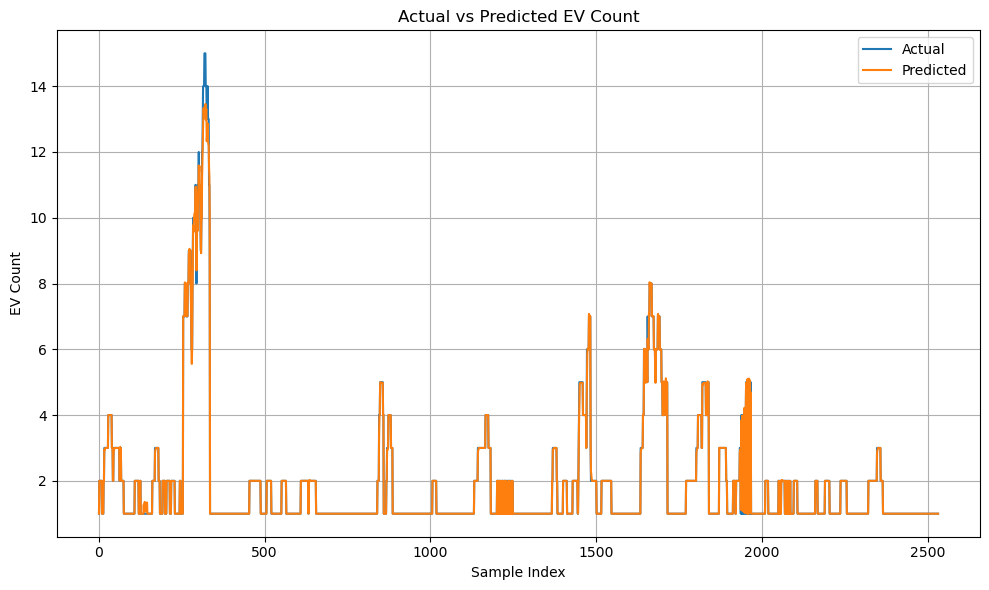

In [28]:
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2Score = r2_score(y_true, y_pred)
    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2 Score: {r2Score:.2f}")

evaluate(y_test, y_pred)

# Plot actual vs predicted
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("Actual vs Predicted EV Count")
plt.xlabel("Sample Index")
plt.ylabel("EV Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

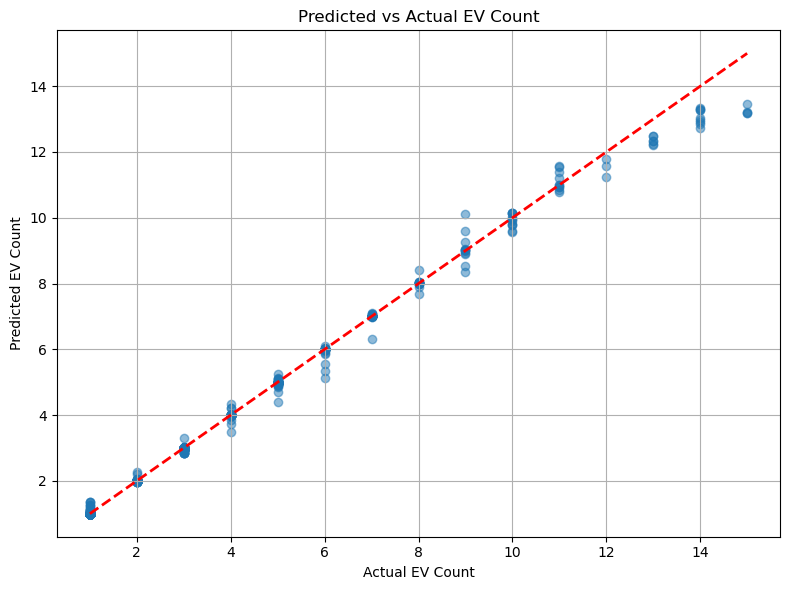

In [29]:
#showing the ideal line(red dotted line) and also to check predictions
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) 
plt.xlabel("Actual EV Count")
plt.ylabel("Predicted EV Count")
plt.title("Predicted vs Actual EV Count")
plt.grid(True)
plt.tight_layout()
plt.show()

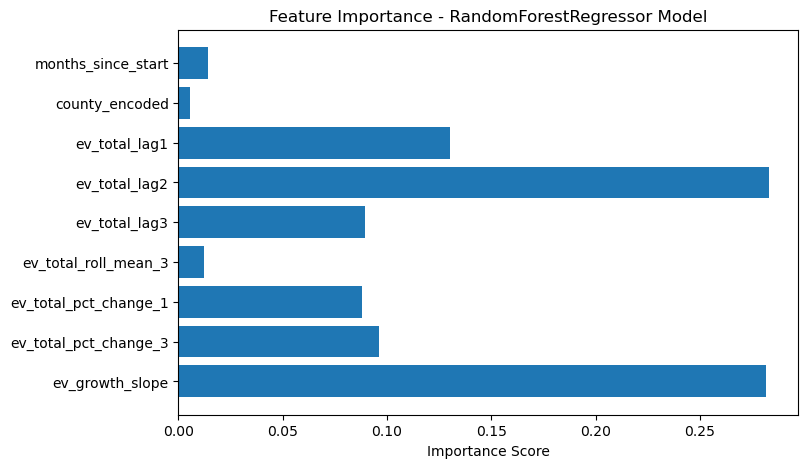

In [30]:
#feature importance
importances = model.feature_importances_

plt.figure(figsize=(8,5))
plt.barh(features, importances)
plt.xlabel('Importance Score')

plt.title('Feature Importance - RandomForestRegressor Model')
plt.gca().invert_yaxis()  
plt.show()

In [31]:
#unique counties
featuresX = ['County', 'county_encoded']

countyX = df[featuresX]


print("List of unique counties:")
print(df['County'].dropna().unique())

print("Total unique counties:", df['County'].nunique())

List of unique counties:
['Ada' 'Adams' 'Alameda' 'Albemarle' 'Alexandria' 'Allegheny' 'Allen'
 'Anchorage' 'Anne Arundel' 'Arapahoe' 'Arlington' 'Atlantic' 'Autauga'
 'Baltimore' 'Bartow' 'Beaufort' 'Bell' 'Bergen' 'Berkeley' 'Berkshire'
 'Bexar' 'Boone' 'Boulder' 'Bradley' 'Brevard' 'Broward' 'Bryan' 'Bucks'
 'Burlington' 'Caddo' 'Calvert' 'Camden' 'Canyon' 'Carroll' 'Carson City'
 'Cascade' 'Champaign' 'Charles' 'Charleston' 'Charlottesville'
 'Chesapeake' 'Clackamas' 'Clark' 'Clay' 'Clinton' 'Cobb' 'Cochise'
 'Collier' 'Collin' 'Columbia' 'Contra Costa' 'Cook' 'Coryell'
 'Cumberland' 'Currituck' 'Dakota' 'Dale' 'Dallas' 'Dane' 'Danville'
 'DeKalb' 'Denton' 'Denver' 'Deschutes' 'District of Columbia'
 'Dorchester' 'Douglas' 'DuPage' 'Duval' 'Eagle' 'Eau Claire' 'El Dorado'
 'El Paso' 'Escambia' 'Essex' 'Fairbanks North Star' 'Fairfax' 'Flathead'
 'Fort Bend' 'Franklin' 'Frederick' 'Fresno' 'Fulton' 'Galveston'
 'Garfield' 'Geary' 'Goochland' 'Greene' 'Guadalupe' 'Gwinnett' 'Hamilton

County 'Kings' encoded as 130.


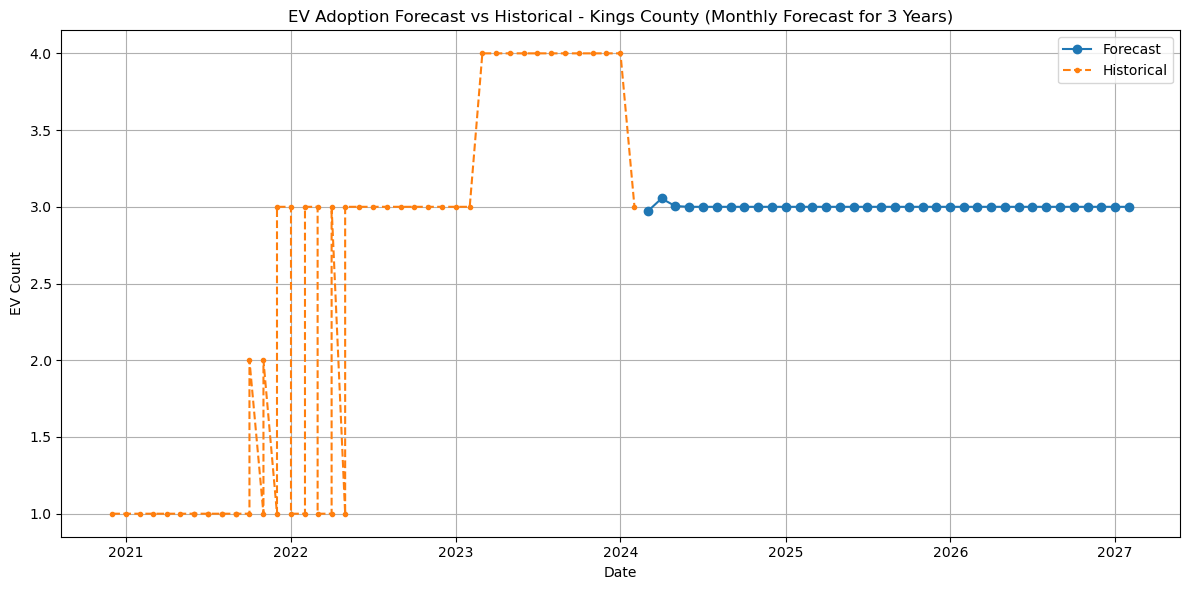

In [32]:
county = "Kings"

# Encode county
try:
    county_code = le.transform([county])[0]
    print(f"County '{county}' encoded as {county_code}.")
except ValueError:
    print(f"Error: '{county}' not found in LabelEncoder.")
    exit()

# Filter historical data
county_df = df[df['county_encoded'] == county_code].sort_values("numeric_date")
if county_df.empty:
    print(f"Warning: No data found for county '{county}'.")
    exit()

# Prepare EV history
historical_ev = list(county_df['Electric Vehicle (EV) Total'].values[-6:])
cumulative_ev = list(np.cumsum(historical_ev))
slope_history = []
months_since_start = county_df['months_since_start'].max()

historical = county_df[['year', 'month', 'numeric_date', 'Electric Vehicle (EV) Total', 'months_since_start']].copy()
historical['Source'] = 'Historical'
historical['Date'] = pd.to_datetime(historical[['year', 'month']].assign(day=1))

# Forecast next 36 months
latest_row = county_df.iloc[-1].copy()
future_rows = []

for i in range(1, 37):
    next_date = pd.to_datetime(latest_row['year'] * 100 + latest_row['month'], format='%Y%m') + pd.DateOffset(months=1)
    y, m = next_date.year, next_date.month
    numeric_date = y * 12 + m
    months_since_start += 1

    lag1, lag2, lag3 = historical_ev[-1], historical_ev[-2], historical_ev[-3]
    roll_mean = np.mean([lag1, lag2, lag3])
    pct_change_1 = (lag1 - lag2) / max(lag2, 1)
    pct_change_3 = (lag1 - lag3) / max(lag3, 1)

    recent_cumulative = cumulative_ev[-6:]
    ev_growth_slope = np.polyfit(range(len(recent_cumulative)), recent_cumulative, 1)[0] if len(recent_cumulative) == 6 else 0

    new_row = {
        'months_since_start': months_since_start,
        'county_encoded': county_code,
        'ev_total_lag1': lag1,
        'ev_total_lag2': lag2,
        'ev_total_lag3': lag3,
        'ev_total_roll_mean_3': roll_mean,
        'ev_total_pct_change_1': pct_change_1,
        'ev_total_pct_change_3': pct_change_3,
        'ev_growth_slope': ev_growth_slope
    }

    X_new = pd.DataFrame([new_row])[features]
    pred = model.predict(X_new)[0]
    new_row['Electric Vehicle (EV) Total'] = pred

    historical_ev.append(pred)
    if len(historical_ev) > 6:
        historical_ev.pop(0)

    cumulative_ev.append(cumulative_ev[-1] + pred)
    if len(cumulative_ev) > 6:
        cumulative_ev.pop(0)

    future_rows.append({
        'Date': next_date,
        'Electric Vehicle (EV) Total': pred,
        'months_since_start': months_since_start,
        'Source': 'Forecast'
    })

    latest_row['year'], latest_row['month'] = y, m

# Forecast DataFrame
forecast_df = pd.DataFrame(future_rows)

historical['Date'] = pd.to_datetime(historical[['year', 'month']].assign(day=1))
historical = historical[['Date', 'Electric Vehicle (EV) Total', 'months_since_start', 'Source']]
combined = pd.concat([historical, forecast_df], ignore_index=True)

plt.figure(figsize=(12, 6))
for source, group in combined.groupby('Source'):
    plt.plot(group['Date'], group['Electric Vehicle (EV) Total'], label=source,
             marker='o' if source == 'Forecast' else '.', linestyle='-' if source == 'Forecast' else '--')

plt.title(f"EV Adoption Forecast vs Historical - {county} County (Monthly Forecast for 3 Years)")
plt.xlabel("Date")
plt.ylabel("EV Count")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

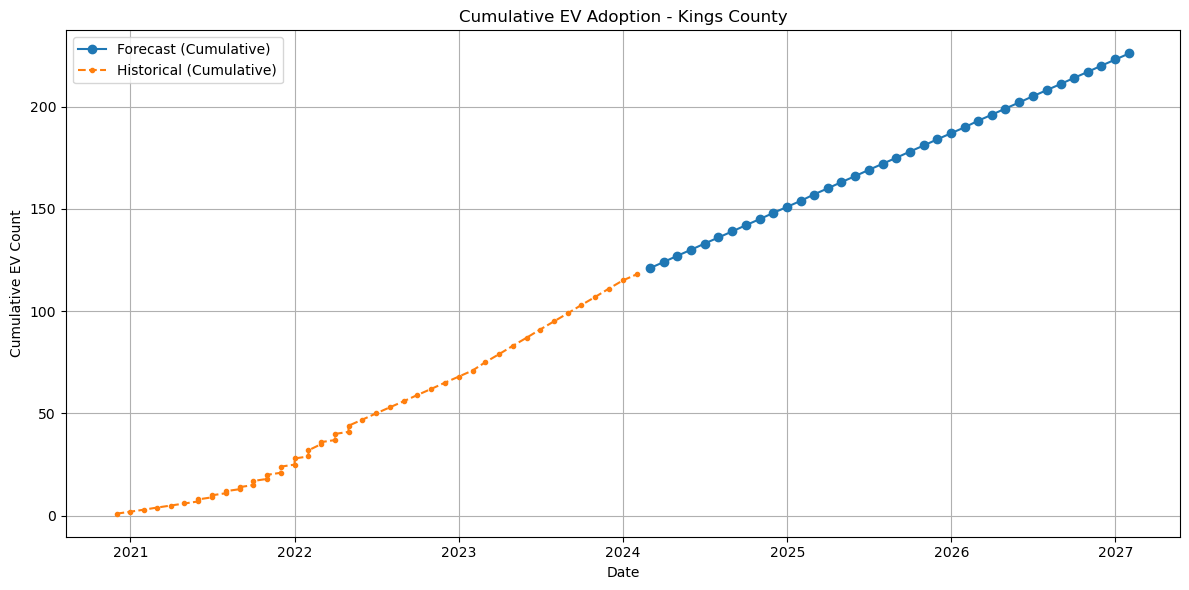

In [33]:
combined = combined.sort_values("Date")

combined['Cumulative EVs'] = combined['Electric Vehicle (EV) Total'].cumsum()

plt.figure(figsize=(12, 6))
for source, group in combined.groupby('Source'):
    plt.plot(group['Date'], group['Cumulative EVs'], label=f'{source} (Cumulative)',
             marker='o' if source == 'Forecast' else '.', linestyle='-' if source == 'Forecast' else '--')

plt.title(f"Cumulative EV Adoption - {county} County")
plt.xlabel("Date")
plt.ylabel("Cumulative EV Count")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

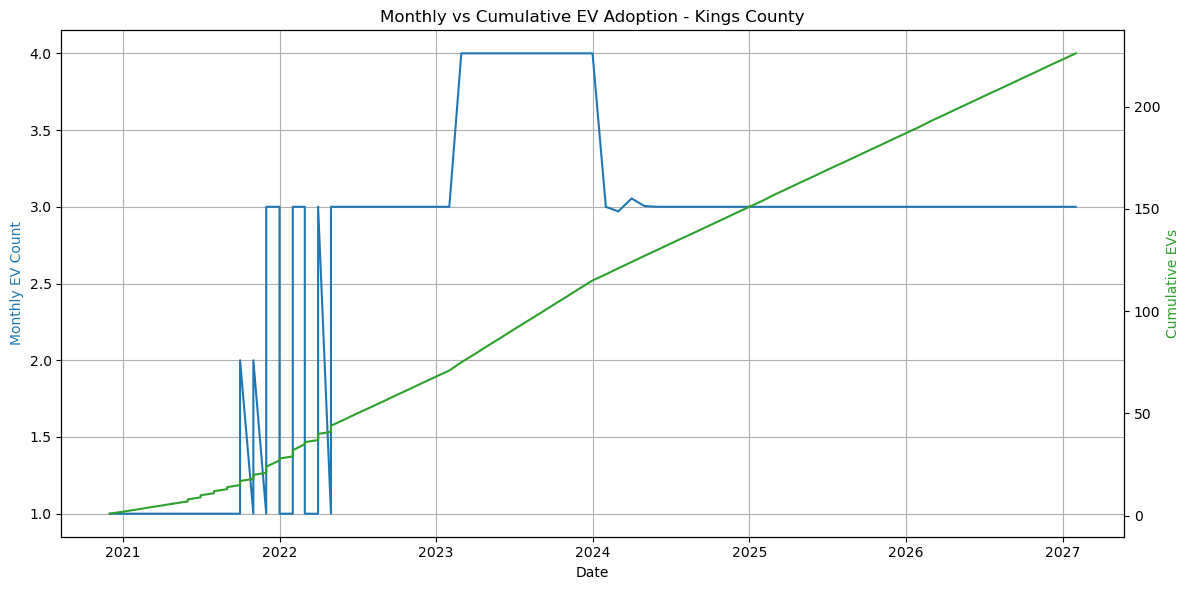

In [34]:
#monthly adoption pace vs overall growth
combined = combined.sort_values("Date")

combined['Cumulative EVs'] = combined['Electric Vehicle (EV) Total'].cumsum()

fig, ax1 = plt.subplots(figsize=(12, 6))

ax2 = ax1.twinx()
ax1.plot(combined['Date'], combined['Electric Vehicle (EV) Total'], color='tab:blue', label='Monthly EV Count')
ax2.plot(combined['Date'], combined['Cumulative EVs'], color='tab:green', label='Cumulative EVs')

ax1.set_xlabel("Date")
ax1.set_ylabel("Monthly EV Count", color='tab:blue')
ax2.set_ylabel("Cumulative EVs", color='tab:green')

plt.title(f"Monthly vs Cumulative EV Adoption - {county} County")
ax1.grid(True)
fig.tight_layout()
plt.show()


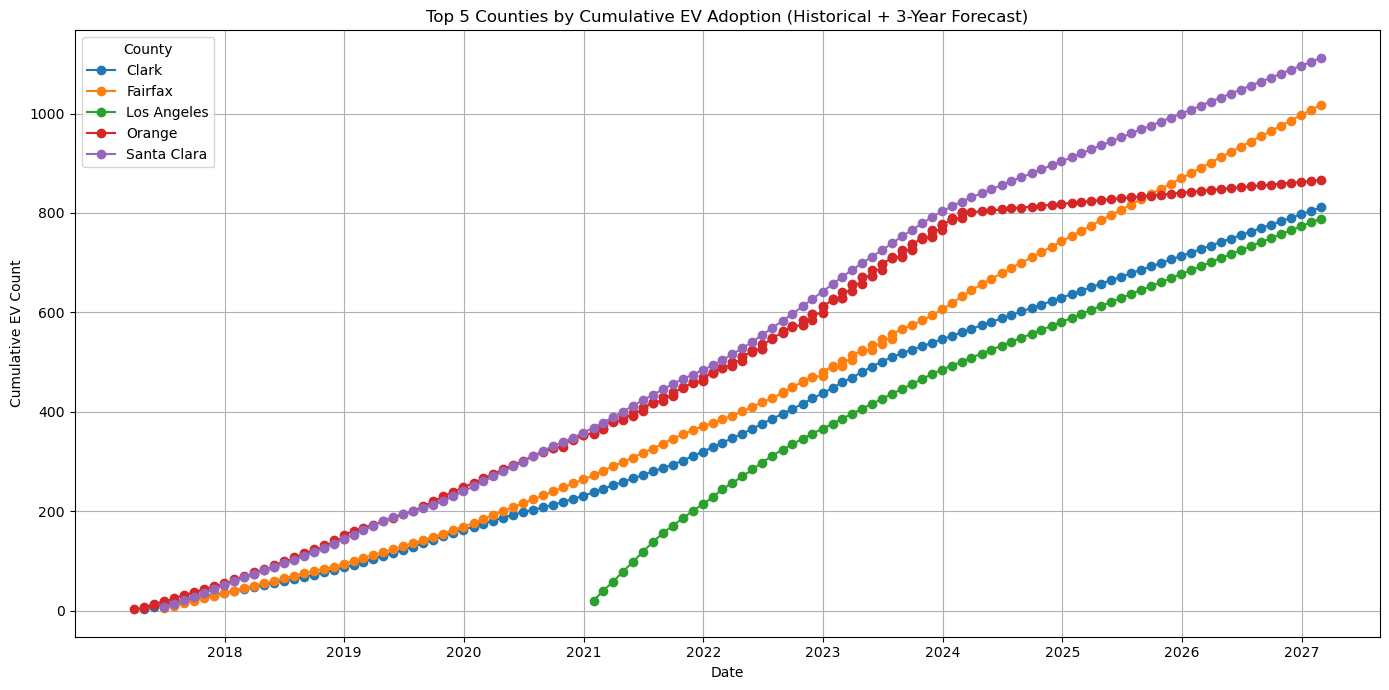

In [35]:
forecast_horizon = 36  # 3 years

all_combined = []
unique_counties = df['County'].dropna().unique()

for county in unique_counties:
    try:
        county_code = le.transform([county])[0]
    except ValueError:
        continue

    county_df = df[df['county_encoded'] == county_code].sort_values("numeric_date")
    if county_df.empty or county_df.shape[0] < 6:
        continue

    months_since_start = county_df['months_since_start'].max()

    historical = county_df[['Date', 'Electric Vehicle (EV) Total', 'months_since_start']].copy()
    historical['Source'] = 'Historical'
    historical['County'] = county

    historical_ev = list(county_df['Electric Vehicle (EV) Total'].values[-6:])
    cumulative_ev = list(np.cumsum(historical_ev))
    slope_history = []

    future_rows = []

    for _ in range(forecast_horizon):
        months_since_start += 1

        lag1, lag2, lag3 = historical_ev[-1], historical_ev[-2], historical_ev[-3]
        roll_mean = np.mean([lag1, lag2, lag3])
        pct_change_1 = (lag1 - lag2) / lag2 if lag2 != 0 else 0
        pct_change_3 = (lag1 - lag3) / lag3 if lag3 != 0 else 0

        recent_cumulative = cumulative_ev[-6:]
        ev_growth_slope = np.polyfit(range(len(recent_cumulative)), recent_cumulative, 1)[0] if len(recent_cumulative) == 6 else 0

        slope_history.append(ev_growth_slope)
        if len(slope_history) > 2:
            slope_history.pop(0)

        new_row = {
            'months_since_start': months_since_start,
            'county_encoded': county_code,
            'ev_total_lag1': lag1,
            'ev_total_lag2': lag2,
            'ev_total_lag3': lag3,
            'ev_total_roll_mean_3': roll_mean,
            'ev_total_pct_change_1': pct_change_1,
            'ev_total_pct_change_3': pct_change_3,
            'ev_growth_slope': ev_growth_slope
        }

        # Predict
        X_new = pd.DataFrame([new_row])[features]
        pred = model.predict(X_new)[0]
        new_row['Electric Vehicle (EV) Total'] = pred

        forecast_date = historical['Date'].max() + pd.DateOffset(months=len(future_rows) + 1)
        future_rows.append({
            'Date': forecast_date,
            'Electric Vehicle (EV) Total': pred,
            'months_since_start': months_since_start,
            'County': county,
            'Source': 'Forecast'
        })

        historical_ev.append(pred)
        if len(historical_ev) > 6:
            historical_ev.pop(0)

        cumulative_ev.append(cumulative_ev[-1] + pred)
        if len(cumulative_ev) > 6:
            cumulative_ev.pop(0)

    forecast_df = pd.DataFrame(future_rows)
    combined = pd.concat([historical, forecast_df], ignore_index=True)
    combined = combined.sort_values("Date")
    combined['Cumulative EVs'] = combined['Electric Vehicle (EV) Total'].cumsum()

    all_combined.append(combined)

full_df = pd.concat(all_combined)

final_totals = full_df.groupby('County')['Cumulative EVs'].max().sort_values(ascending=False)
top_5_counties = final_totals.head(5).index.tolist()

top_5_df = full_df[full_df['County'].isin(top_5_counties)]

# Plot
plt.figure(figsize=(14, 7))
for county, group in top_5_df.groupby('County'):
    plt.plot(group['Date'], group['Cumulative EVs'], label=county, marker='o')

# Format x-axis to show one tick per year
plt.title("Top 5 Counties by Cumulative EV Adoption (Historical + 3-Year Forecast)")
plt.xlabel("Date")
plt.ylabel("Cumulative EV Count")
plt.grid(True)
plt.legend(title="County")
plt.xticks(
    ticks=pd.date_range(start=top_5_df['Date'].min(), end=top_5_df['Date'].max(), freq='YS'),
    labels=[str(d.year) for d in pd.date_range(start=top_5_df['Date'].min(), end=top_5_df['Date'].max(), freq='YS')],
    rotation=0
)
plt.tight_layout()
plt.show()

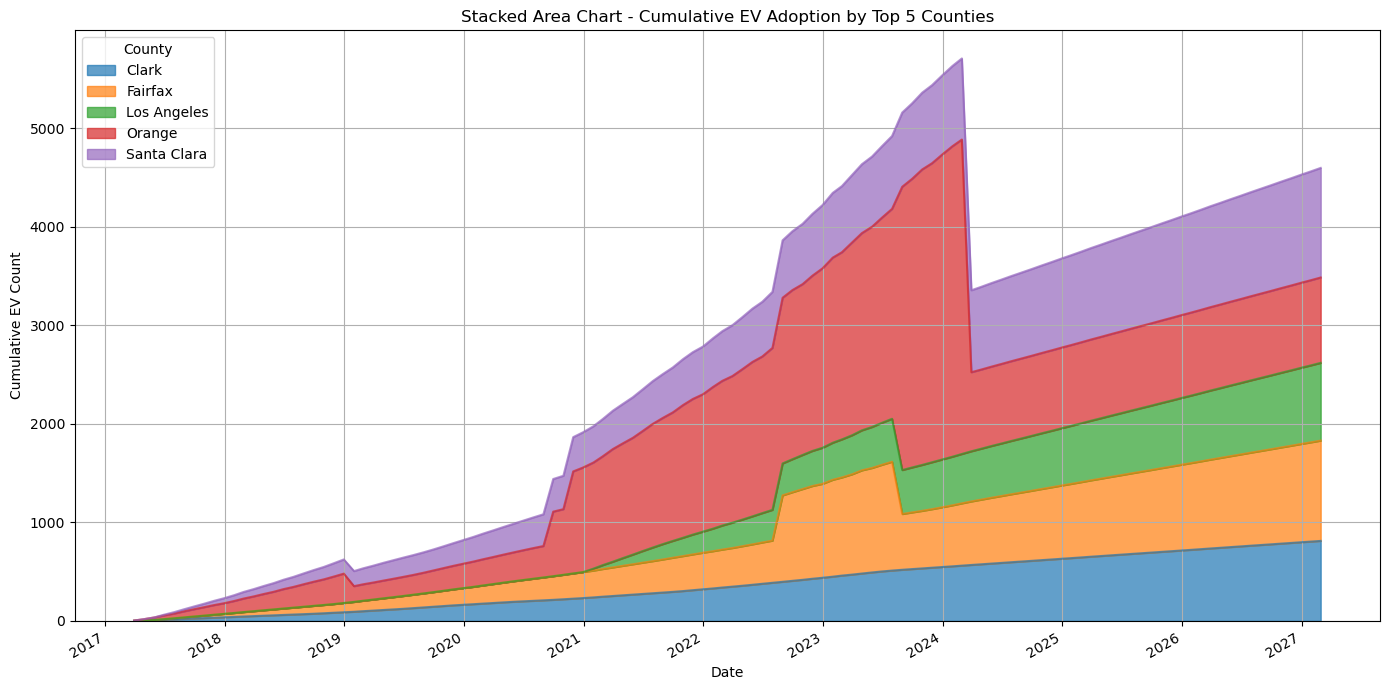

In [37]:
#stacked area chart
pivot_df = pd.pivot_table(
    top_5_df,
    index='Date',
    columns='County',
    values='Cumulative EVs',
    aggfunc='sum'  # could also be 'mean'
).ffill()

pivot_df.plot.area(figsize=(14, 7), alpha=0.7)
plt.title("Stacked Area Chart - Cumulative EV Adoption by Top 5 Counties")
plt.xlabel("Date")
plt.ylabel("Cumulative EV Count")
plt.grid(True)
plt.legend(title="County", loc="upper left")
plt.tight_layout()
plt.show()

In [38]:
joblib.dump(model, 'forecasting_ev_model.pkl')
print("Model saved to 'forecasting_ev_model.pkl'")

Model saved to 'forecasting_ev_model.pkl'


In [39]:
# Load model from file
loaded_model = joblib.load('forecasting_ev_model.pkl')
print("Model loaded successfully.")

Model loaded successfully.


In [47]:
# Test prediction on new or existing sample
sample = X_test.iloc[[2]]  # use one row as test
true_value = y_test.iloc[2]
predicted_value = loaded_model.predict(sample)[0]

print(f"\n🔍 Testing saved model on sample index 2:")
print(f"Actual EVs: {true_value:.2f}, Predicted EVs: {predicted_value:.2f}")


🔍 Testing saved model on sample index 2:
Actual EVs: 2.00, Predicted EVs: 2.00
